In [1]:
library(ggplot2)
library(patchwork)

options(warn=-1)

In [2]:
rm(list = ls())
set.seed(1234)
P = 90
N = 200
p = P/3
pi = 0.05

k=0
while(T){
  k=k+1

  Pre1 = matrix(sample(c(0.2, 0.4), p*p, replace = T) * rbinom(p*p, 1, pi), nrow = p, ncol = p )
  Pre1[lower.tri(Pre1)] = t(Pre1)[lower.tri(Pre1)]
  diag(Pre1) = 1

  Pre2 = 5 * Pre1
  Pre3 = 25 * Pre1
  Pre = Matrix::bdiag(Pre1, Pre2, Pre3)

  vals <- eigen(Pre)$values

  if(is.complex(vals) ) next
  if(all(vals>0.01)) {
    Pre = as.matrix(Pre)
    Sigma = solve(Pre)
    Z = MASS::mvrnorm(N, rep(0, P), Sigma)
    cat('Succeed.')
    break
  }
  if(k>100){
    cat('Failed.')
    break
  } 
}

Succeed.

[1]  0 25

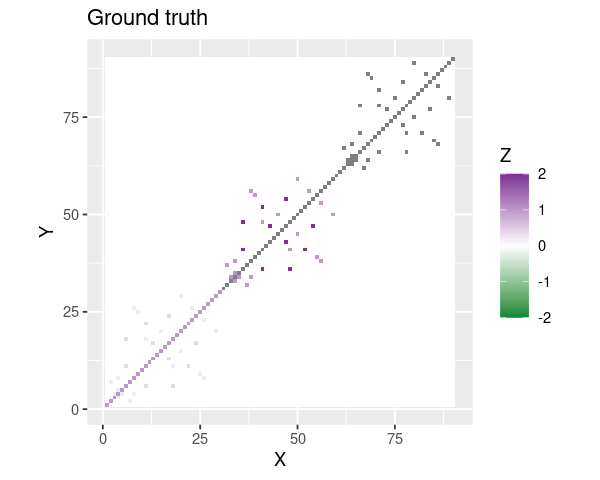

In [3]:
options(repr.plot.width=5, repr.plot.height=4)
X=Y=1:P
df=expand.grid(X=X, Y=Y)
range(Pre)
df$Z=c(Pre)
ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('Ground truth') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-2, 2))

In [4]:
source('../tools.R')
source('../FLAG.R')
Z.c = scale(Z, center = T, scale = F)
Z.s = scale(Z, center = T, scale = T)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [5]:
MLE.c = run.mle(Z.c)
CLIME.c = run.clime(Z.c, lambda=0.1)
OM.c = OurMethod(Z.c, crit.loglik=1e-7)
ANT.c = run.ant(Z.c)
BGGM.c = run.bggm(Z.c)
GLASSO.c = run.glasso(Z.c)
cat('Lambda of GLasso:', GLASSO.c$lambda, '\n')
HGL.c = run.hglasso(Z.c)
DSGL.c = SILGGM::SILGGM(Z.c, method='D-S_GL')

Allocating memory 
start recovering 
preparing precision and path matrix list 
Done! 
Some columns do not reach the required lambda!
 You may want to increase lambda.min or use a larger nlambda. 


Registered S3 methods overwritten by 'BFpack':
  method               from
  get_estimates.lm     bain
  get_estimates.t_test bain

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



  |======================================================================| 100%Lambda of GLasso: 0.06309573 
Use method '"D-S_GL"'
Use default lambda = sqrt(log(p)/n)
In this case, lambda = 0.149997
Center each column.
Pre-calculate inner product matrixes.
Calculate graphical Lasso.


In [6]:
MLE.s = run.mle(Z.s)
CLIME.s = run.clime(Z.s, lambda=0.1)
OM.s = OurMethod(Z.s, crit.loglik=1e-7)
ANT.s = run.ant(Z.s)
BGGM.s = run.bggm(Z.s)
GLASSO.s = run.glasso(Z.s)
cat('Lambda of GLasso:', GLASSO.s$lambda, '\n')
HGL.s = run.hglasso(Z.s)
DSGL.s = SILGGM::SILGGM(Z.s, method='D-S_GL')

Allocating memory 
start recovering 
preparing precision and path matrix list 
Done! 
  |======================================================================| 100%Lambda of GLasso: 0.1584893 
Use method '"D-S_GL"'
Use default lambda = sqrt(log(p)/n)
In this case, lambda = 0.149997
Center each column.
Pre-calculate inner product matrixes.
Calculate graphical Lasso.


### Get partial correlation

In [7]:
true.pc = prec2pc(Pre)

MLE.c.pc = prec2pc(MLE.c)
CLIME.c.pc = prec2pc(CLIME.c$icov)
OM.c.pc = prec2pc(OM.c$precision.est)
ANT.c.pc = prec2pc(ANT.c$precision)
BGGM.c.pc = prec2pc(BGGM.c$precision)
GLASSO.c.pc = prec2pc(GLASSO.c$wi)
HGL.c.pc = prec2pc(HGL.c$Theta)
DSGL.c.pc = prec2pc(DSGL.c$precision)

MLE.s.pc = prec2pc(MLE.s)
CLIME.s.pc = prec2pc(CLIME.s$icov)
OM.s.pc = prec2pc(OM.s$precision.est)
ANT.s.pc = prec2pc(ANT.s$precision)
BGGM.s.pc = prec2pc(BGGM.s$precision)
GLASSO.s.pc = prec2pc(GLASSO.s$wi)
HGL.s.pc = prec2pc(HGL.s$Theta)
DSGL.s.pc = prec2pc(DSGL.s$precision)

# 0. Visualize partial correlation

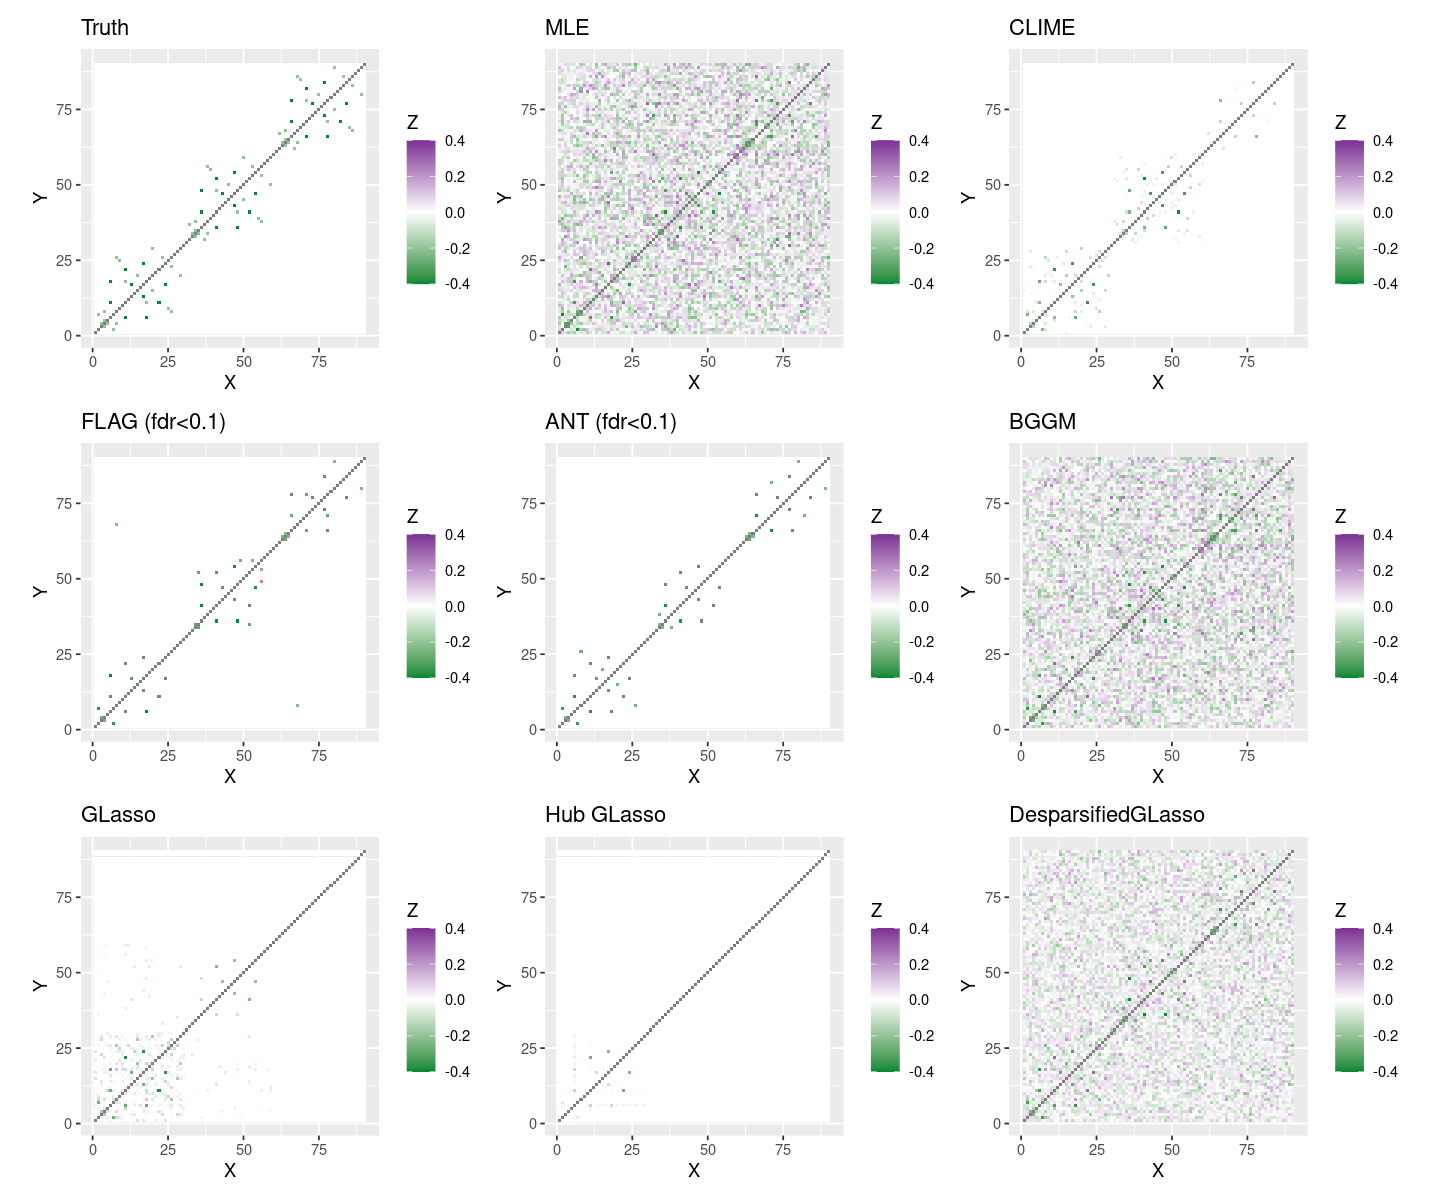

In [8]:
# centered
X=Y=1:P
bound=0.4
df=expand.grid(X=X, Y=Y)
df$Z=c(true.pc)
p1=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('Truth') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z = c(MLE.c.pc)
p2=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('MLE') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z=c(CLIME.c.pc)
p3=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('CLIME') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
om.c.adj = get.fdr(OM.c$precision.pval, thr=0.1, diag.val=1)
df$Z=c(OM.c.pc * om.c.adj)
p4=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('FLAG (fdr<0.1)') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
ant.c.adj = get.fdr(ANT.c$p_precision, thr=0.1, diag.val=1)
df$Z=c(ANT.c.pc * ant.c.adj)
p5=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('ANT (fdr<0.1)') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z=c(BGGM.c.pc)
p6=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('BGGM') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))

df$Z=c(GLASSO.c.pc)
p7=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('GLasso') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z=c(HGL.c.pc)
p8=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('Hub GLasso') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z=c(DSGL.c.pc)
p9=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('DesparsifiedGLasso') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))

options(repr.plot.width=12, repr.plot.height=10)
p1+p2+p3+p4+p5+p6+p7+p8+p9+plot_layout(ncol = 3)

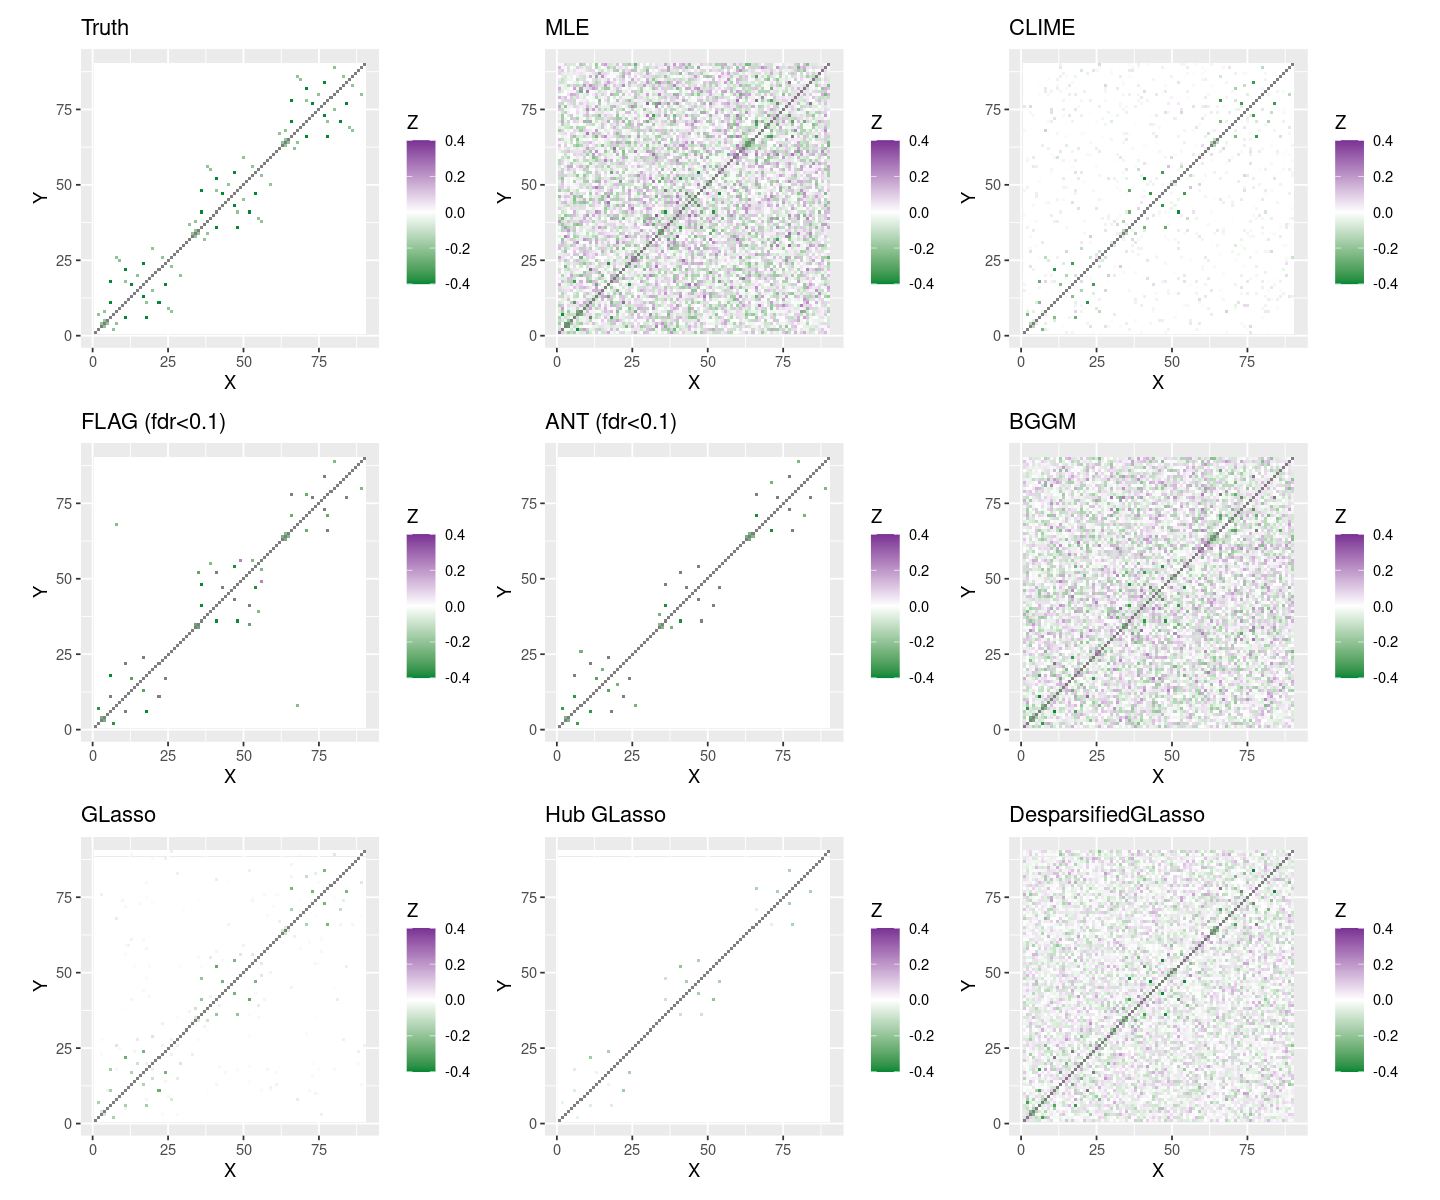

In [9]:
# centered
X=Y=1:P
bound=0.4
df=expand.grid(X=X, Y=Y)
df$Z=c(true.pc)
p1=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('Truth') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z = c(MLE.s.pc)
p2=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('MLE') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z=c(CLIME.s.pc)
p3=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('CLIME') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
om.s.adj = get.fdr(OM.s$precision.pval, thr=0.1, diag.val=1)
df$Z=c(OM.s.pc * om.s.adj)
p4=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('FLAG (fdr<0.1)') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
ant.s.adj = get.fdr(ANT.s$p_precision, thr=0.1, diag.val=1)
df$Z=c(ANT.s.pc * ant.s.adj)
p5=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('ANT (fdr<0.1)') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z=c(BGGM.s.pc)
p6=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('BGGM') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))

df$Z=c(GLASSO.s.pc)
p7=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('GLasso') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z=c(HGL.s.pc)
p8=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('Hub GLasso') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))
df$Z=c(DSGL.s.pc)
p9=ggplot(df, aes(X, Y, fill= Z)) + geom_tile(aes(fill = Z)) + ggtitle('DesparsifiedGLasso') + coord_fixed() +
    scale_fill_gradient2(low = "#008837", high = "#7b3294", mid = "white", midpoint = 0, limits=c(-bound, bound))

options(repr.plot.width=12, repr.plot.height=10)
p1+p2+p3+p4+p5+p6+p7+p8+p9+plot_layout(ncol = 3)

# 1. scatter plot

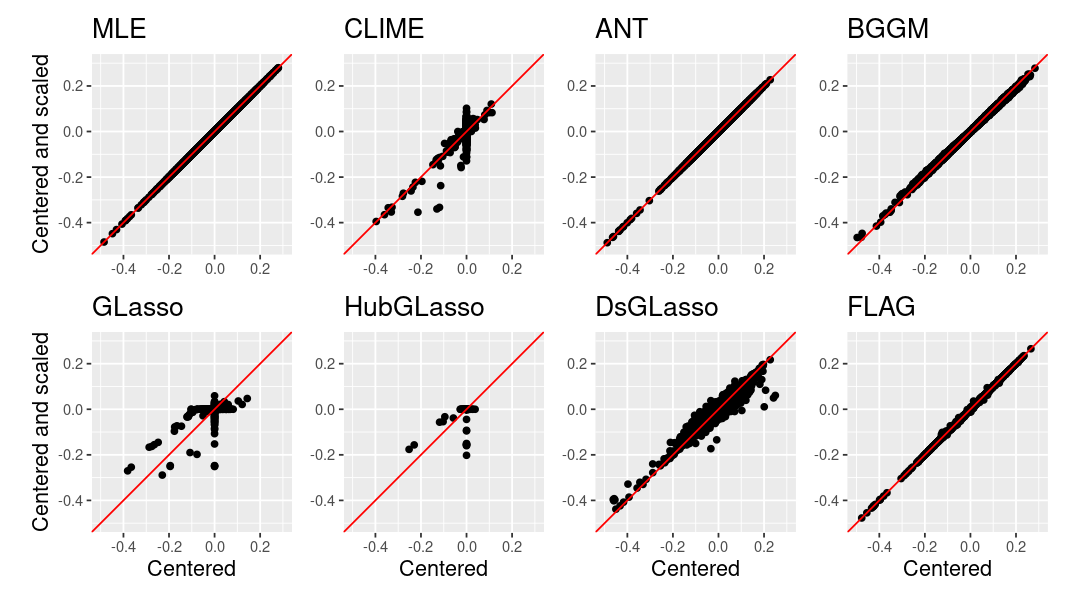

In [14]:
plot.scatter<-function(c.pc, s.pc, title,lower=-0.5,upper=0.3){
  df = data.frame(X = c( get.tri(c.pc) ), Y = c( get.tri(s.pc) ))
  ggplot(df, aes(x=X, y=Y)) + geom_point(size=1.5) + geom_abline(intercept = 0, slope = 1, color='red') +
  coord_fixed() + ggtitle(title) +xlim(lower,upper)+ylim(lower,upper) +
  theme(plot.title = element_text(size = 16), axis.title = element_text(size = 13))
}
options(repr.plot.width=9, repr.plot.height=5)
plot.scatter(MLE.c.pc, MLE.s.pc, 'MLE')+ xlab(NULL) + ylab('Centered and scaled') +
plot.scatter(CLIME.c.pc, CLIME.s.pc, 'CLIME')+ xlab(NULL) + ylab(NULL) +
plot.scatter(ANT.c.pc, ANT.s.pc, 'ANT')+ xlab(NULL) + ylab(NULL) +
plot.scatter(BGGM.c.pc, BGGM.s.pc, 'BGGM')+ xlab(NULL) + ylab(NULL) +
plot.scatter(GLASSO.c.pc, GLASSO.s.pc, 'GLasso') + xlab('Centered') + ylab('Centered and scaled') +
plot.scatter(HGL.c.pc, HGL.s.pc, 'HubGLasso') + xlab('Centered') + ylab(NULL) +
plot.scatter(DSGL.c.pc, DSGL.s.pc, 'DsGLasso') + xlab('Centered') + ylab(NULL) +
plot.scatter(OM.c.pc, OM.s.pc, 'FLAG') + xlab('Centered') + ylab(NULL) + plot_layout(ncol = 4)